In [ ]:
## Parameters

dataset_url = 'https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz'
dest = ''
use_google_drive = False
saving_path = dest + 'Bootcamp/Model/'

target_size = (225, 225)
batch_size = 32

## Making Directories

!mkdir 'Bootcamp/'
!mkdir 'Bootcamp/Model/'
!mkdir 'Bootcamp/Data/'

### Importing Data and Packages


In [ ]:
!pip install gdown
!pip install imblearn
!pip install opencv-python

#### Packages

In [ ]:
## Required Packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import gdown
import zipfile

import os
import cv2

from PIL import Image

from tensorflow import keras
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, Input, concatenate
from keras.utils import to_categorical
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import GlorotNormal, HeNormal
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2
from tensorflow.keras.applications import InceptionV3, MobileNet, Xception, VGG16, InceptionResNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from sklearn.metrics import confusion_matrix, f1_score

#### Functions

In [ ]:
def read_img(dataset, shape_info = False):

    data = []
    for index, row in dataset.iterrows():

        image = cv2.imread(row['dest'])

        try:
            if shape_info:
                height, width, channels = image.shape
                data.append({'name': row['name'], 'height': height, 'width': width, 'channels': channels})
            else:
                data.append({'name': row['name'], 'image': image})
        except:
            pass

    return pd.DataFrame(data)

In [ ]:
## Data Generator Function

class DataGenerator(keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, target_size=None, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indices = np.arange(len(dataframe))

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = self.dataframe.iloc[indices]

        X = np.zeros((len(batch), *self.target_size, 3))
        y = np.zeros((len(batch), len(categories)))

        for i, (image_path, label) in enumerate(zip(batch['image_path'], batch['label'])):

            if target_size != None:
                image = Image.open(image_path).resize(self.target_size)
            else:
                image = Image.open(image_path)

            X[i] = np.array(image) / 255.0 ## Normalizing Data
            y[i, label] = 1

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
def Saving_Model_Output(path, history, model_name):

    path_model = path + model_name + '.json'
    path_weights = path + model_name + '.h5'
    path_history = path + 'history_' + model_name + '.npy'

    # serialize model to JSON
    model_json = model.to_json()
    with open(path_model, "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(path_weights)

    # saving model history
    np.save(path_history,history.history)


def Load_Model(path, model_name):

    path_model = path + model_name + '.json'
    path_weights = path + model_name + '.h5'
    path_history = path + 'history_' + model_name + '.npy'

    json_file = open(path_model, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights(path_weights)

    history = np.load(path_history,allow_pickle='TRUE').item()

    return model, history

In [ ]:
def compiling_block(model):

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    min_delta=0.1,
                                                    patience=10,
                                                    restore_best_weights=True)

    history = model.fit_generator(generator=train_generator,
                                    validation_data=valid_generator,
                                    epochs=30,
                                    shuffle=False,
                                    callbacks=[early_stopping])

    return history

In [ ]:
import itertools
def train_val_plot(models_hist, models_name, title):
    num_models = len(models_hist)
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for mod_idx in range(num_models):
        axs[0, 0].plot([i+1 for i in range(len(models_hist[mod_idx]['val_accuracy']))], models_hist[mod_idx]['val_accuracy'], label=models_name[mod_idx])
        axs[1, 0].plot([i+1 for i in range(len(models_hist[mod_idx]['val_accuracy']))], models_hist[mod_idx]['val_loss'], label=models_name[mod_idx])
        axs[0, 1].plot([i+1 for i in range(len(models_hist[mod_idx]['accuracy']))], models_hist[mod_idx]['accuracy'], label=models_name[mod_idx])
        axs[1, 1].plot([i+1 for i in range(len(models_hist[mod_idx]['accuracy']))], models_hist[mod_idx]['loss'], label=models_name[mod_idx])

    axs[0, 0].set_title(title + ' - Validation Accuracy')
    axs[0, 0].legend()
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')

    axs[1, 0].set_title(title + ' - Validation Loss')
    axs[1, 0].legend()
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')

    axs[0, 1].set_title(title + ' - Training Accuracy')
    axs[0, 1].legend()
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')

    axs[1, 1].set_title(title + ' - Training Loss')
    axs[1, 1].legend()
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Loss')

    plt.tight_layout()
    plt.show()


def evaluate_models(models, validation_generator):
    models_true_labels = []
    models_pred_labels = []

    for model in models:
        true_labels = []
        pred_labels = []

        for i in range(len(validation_generator)):
            data, labels = validation_generator[i]
            predictions = model.predict(data)
            pred_labels.extend(np.argmax(predictions, axis=1))
            true_labels.extend(np.argmax(labels, axis=1))

        models_true_labels.append(true_labels)
        models_pred_labels.append(pred_labels)

    return models_true_labels, models_pred_labels


def plot_confusion_matrix(models_true_labels, models_pred_labels, models_names):
    num_models = len(models_true_labels)

    for idx in range(num_models):
        cm = confusion_matrix(models_true_labels[idx], models_pred_labels[idx])
        f1_micro = f1_score(models_true_labels[idx], models_pred_labels[idx], average='micro')

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"{models_names[idx]} - F1 Micro Score: {f1_micro:.4f}")
        plt.colorbar()

        tick_marks = np.arange(len(cm))
        plt.xticks(tick_marks, tick_marks)
        plt.yticks(tick_marks, tick_marks)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()


#### Downloading DataSet and Preview

In [ ]:
## Mounting Google Drive
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

## Downloading and unzipping data

url = dataset_url
output_path = dest + 'Bootcamp/Data/train.zip'
gdown.download(url, output_path, quiet=False)

zip_file_path = dest + 'Bootcamp/Data/train.zip'
zip_file_saving_path = dest = 'Bootcamp/Data/train'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(zip_file_saving_path)

Downloading...
From (original): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz
From (redirected): https://drive.google.com/uc?id=15CHt2ueS4c7emHpmzFHC3c0TGd51Mnvz&confirm=t&uuid=5a21d980-a911-4f3c-b1f6-877593ebf2fa
To: /content/Bootcamp/Data/train.zip
100%|██████████| 898M/898M [00:11<00:00, 77.0MB/s]


In [ ]:
## Reading Path of images

data = []

for folders, _, files in os.walk(zip_file_saving_path):
    for file in files:
        folder_name = folders.split('/')[-1]

        dest = f'{folders}/{file}'

        data.append({'name': file, 'label': folder_name, 'dest': dest})

df = pd.DataFrame(data)

print(df.shape)
df.head()

(24089, 3)


,name,label,dest
0,03fff39f-28e.jpg,chocolate_cake,Bootcamp/Data/train/train/chocolate_cake/03fff...
1,5b9c788d-246.jpg,chocolate_cake,Bootcamp/Data/train/train/chocolate_cake/5b9c7...
2,d14bd2eb-4ee.jpg,chocolate_cake,Bootcamp/Data/train/train/chocolate_cake/d14bd...
3,cb577970-0f5.jpg,chocolate_cake,Bootcamp/Data/train/train/chocolate_cake/cb577...
4,c9da35a4-608.jpg,chocolate_cake,Bootcamp/Data/train/train/chocolate_cake/c9da3...


In [ ]:
## Counting Labels --> they are imbalanced
print(df['label'].value_counts())

label
donuts             2395
hamburger          2376
chicken            2293
french_fries       2286
spaghetti          1509
baked_potato       1501
hot_dog            1057
pizza               887
omelette            715
falafel             709
caesar_salad        709
cheese_sandwich     708
fish                708
chicken_curry       707
ice_cream           705
chocolate_cake      702
eggs                699
lasagna             693
sushi               690
steak               681
baklava             680
cheesecake          679
Name: count, dtype: int64


### Preprocessing

In [ ]:
### Removing NoneType images

removing_images = ['6fcf7983-225.jpg', '1b4ed8be-285.jpg', '2a2a3166-2d2.jpg', 'e5574159-a60.jpg', '052f1133-141.jpg'] ##None Type Images
df = df[~df.name.isin(removing_images)]

y = df['label']
X = df.drop(columns = ['label'])
df.shape

(24084, 3)

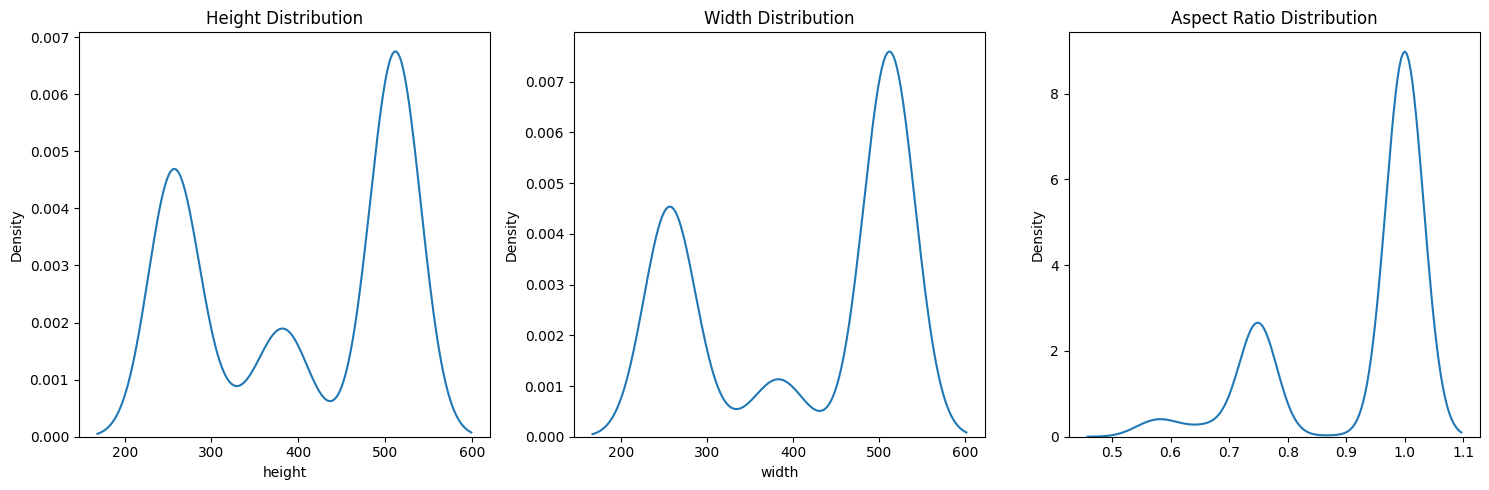

In [ ]:
### Showing Distribution Of aspect ratio and size of images based on random sample

selected_idx = np.random.choice(df.shape[0], 1000)
dataset_preview = read_img(df.iloc[selected_idx,:], shape_info=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.kdeplot(dataset_preview['height'], ax=axes[0])
axes[0].set_title('Height Distribution')

sns.kdeplot(dataset_preview['width'], ax=axes[1])
axes[1].set_title('Width Distribution')

aspect_ratio = pd.DataFrame([dataset_preview['height'] / dataset_preview['width'],
                             dataset_preview['width'] / dataset_preview['height']]).min()
sns.kdeplot(aspect_ratio, ax=axes[2])
axes[2].set_title('Aspect Ratio Distribution')

plt.tight_layout()
plt.show()

In [ ]:
### Encoding Labels into Numbers

from sklearn.preprocessing import LabelEncoder

categories = y.unique()
label_encoder = LabelEncoder()
encoded_categories = label_encoder.fit_transform(categories).tolist()
display(pd.DataFrame({'food': categories, 'encoded_label': encoded_categories}))

y = label_encoder.transform(y)

,food,encoded_label
0,chocolate_cake,7
1,cheesecake,4
2,chicken_curry,6
3,lasagna,16
4,eggs,9
5,steak,20
6,baklava,1
7,spaghetti,19
8,fish,11
9,chicken,5


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_valid))
print("Test set size:", len(X_test))

Training set size: 16858
Validation set size: 3613
Test set size: 3613


In [ ]:
## Random Undersampling

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

## Number of samples in each categories
from collections import Counter
print(Counter(y_res))

Counter({0: 457, 1: 457, 2: 457, 3: 457, 4: 457, 5: 457, 6: 457, 7: 457, 8: 457, 9: 457, 10: 457, 11: 457, 12: 457, 13: 457, 14: 457, 15: 457, 16: 457, 17: 457, 18: 457, 19: 457, 20: 457, 21: 457})


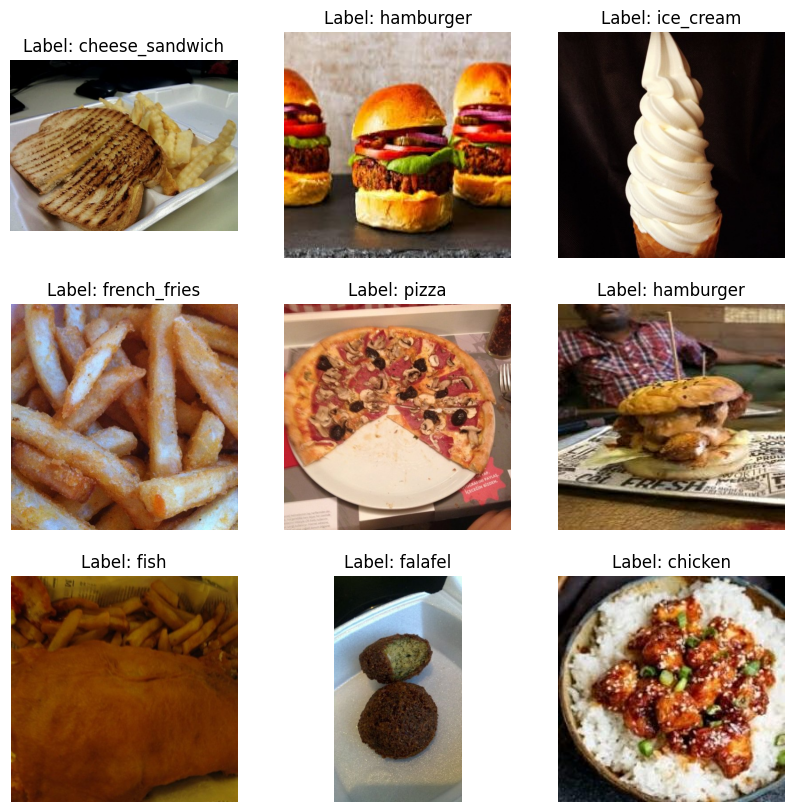

In [ ]:
### Showing Some Images

selected_idx = np.random.choice(X_train.shape[0], 9)
plot_X = read_img(X_train.iloc[selected_idx, :])

plot_y = [sorted(categories)[label] for label in y_train[selected_idx]]

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    image_rgb = cv2.cvtColor(plot_X['image'][i], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)

    plt.title(f"Label: {plot_y[i]}")
    plt.axis('off')
plt.show()

## Model

In [ ]:
df_train = pd.DataFrame({'image_path': X_res.dest.tolist(), 'label': y_res.tolist()})
df_valid = pd.DataFrame({'image_path': X_valid.dest.tolist(), 'label': y_valid.tolist()})

train_generator = DataGenerator(dataframe=df_train, batch_size=batch_size, target_size=target_size)
valid_generator = DataGenerator(dataframe=df_valid, batch_size=batch_size, target_size=target_size)

#### Models

In [ ]:
## VGG

model = VGG16(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_VGG_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_VGG_imagenet, 'VGG_imagenet')

In [ ]:
## AlexNet

model = Sequential()
model.add(Conv2D(96, (11, 11), strides=(4, 4), padding='valid', input_shape=(target_size[0], target_size[1], 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(len(categories)))
model.add(Activation('softmax'))

history_AlexNet = compiling_block(model)
Saving_Model_Output(saving_path, history_AlexNet, 'AlexNet')

In [ ]:
## ResNet50

model = ResNet50(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_ResNet50_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_ResNet50_imagenet, 'ResNet50_imagenet')

In [ ]:
## ResNet101

model = ResNet101(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_ResNet101_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_ResNet101_imagenet, 'ResNet101_imagenet')

In [ ]:
## ResNet152

model = ResNet152(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_ResNet152_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_ResNet152_imagenet, 'ResNet152_imagenet')

In [ ]:
## InceptionV3

model = InceptionV3(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_InceptionV3_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_InceptionV3_imagenet, 'InceptionV3_imagenet')

In [ ]:
## MobileNet

model = MobileNet(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_MobileNet_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_MobileNet_imagenet, 'MobileNet_imagenet')

In [ ]:
## Xception

model = Xception(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_Xception_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_Xception_imagenet, 'Xception_imagenet')

In [ ]:
## InceptionResNetV2

model = InceptionResNetV2(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_InceptionResNetV2_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_InceptionResNetV2_imagenet, 'InceptionResNetV2_imagenet')

In [ ]:
## DenseNet121

model = DenseNet121(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_DenseNet121_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_DenseNet121_imagenet, 'DenseNet121_imagenet')

In [ ]:
## DenseNet169

model = DenseNet169(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_DenseNet169_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_DenseNet169_imagenet, 'DenseNet169_imagenet')

In [ ]:
## DenseNet201

model = DenseNet201(weights='imagenet',
                 classes=len(categories),
                 include_top=False,
                 pooling='avg',
                 input_shape=(target_size[0], target_size[1], 3))

x = Dense(units=len(categories), activation='softmax')(model.output)
model = Model(model.input, x)

history_DenseNet201_imagenet = compiling_block(model)
Saving_Model_Output(saving_path, history_DenseNet201_imagenet, 'DenseNet169_imagenet')

## Model Evaluation

In [ ]:
## Loading Saved Models

VGG_imagenet, history_VGG_imagenet= Load_Model(saving_path, 'VGG_imagenet') #
AlexNet_imagenet, history_AlexNet_imagenet= Load_Model(saving_path, 'AlexNet')
# ResNet50_imagenet, history_ResNet50_imagenet= Load_Model(saving_path, 'ResNet50_imagenet')
ResNet101_imagenet, history_ResNet101_imagenet= Load_Model(saving_path, 'ResNet101_imagenet')
ResNet152_imagenet, history_ResNet152_imagenet= Load_Model(saving_path, 'ResNet152_imagenet')
InceptionV3_imagenet, history_InceptionV3_imagenet= Load_Model(saving_path, 'InceptionV3_imagenet') #
MobileNet_imagenet, history_MobileNet_imagenet= Load_Model(saving_path, 'MobileNet_imagenet') #
Xception_imagenet, history_Xception_imagenet= Load_Model(saving_path, 'Xception_imagenet') #
# InceptionResNetV2_imagenet, history_InceptionResNetV2_imagenet= Load_Model(saving_path, 'InceptionResNetV2_imagenet')
DenseNet121_imagenet, history_DenseNet121_imagenet= Load_Model(saving_path, 'DenseNet121_imagenet')
DenseNet169_imagenet, history_DenseNet169_imagenet= Load_Model(saving_path, 'DenseNet169_imagenet')
# DenseNet201_imagenet, history_DenseNet201_imagenet= Load_Model(saving_path, 'DenseNet201_imagenet')

#### Train Validation Accuracy

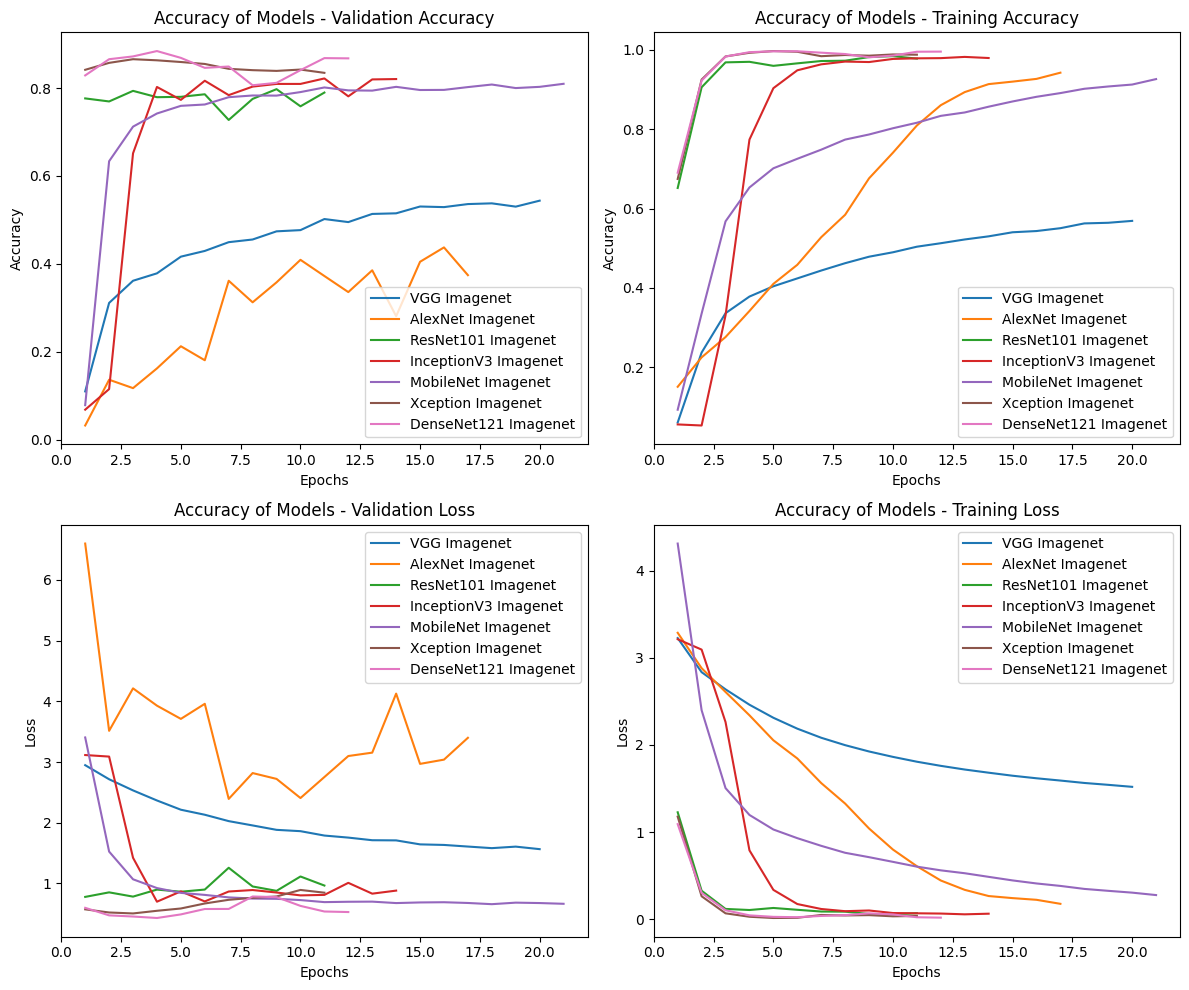

In [ ]:
models_hist = [history_VGG_imagenet, history_AlexNet_imagenet, history_ResNet50_imagenet,
               history_InceptionV3_imagenet, history_MobileNet_imagenet, history_Xception_imagenet,
               history_InceptionResNetV2_imagenet, history_DenseNet121_imagenet]

models_name = ['VGG Imagenet', 'AlexNet Imagenet', 'ResNet50 Imagenet',
               'InceptionV3 Imagenet', 'MobileNet Imagenet', 'Xception Imagenet',
               'InceptionResNetV2 Imagenet', 'DenseNet121 Imagenet']


# models_hist = [history_VGG_imagenet, history_AlexNet_imagenet, history_ResNet101_imagenet,
#                history_InceptionV3_imagenet, history_MobileNet_imagenet, history_Xception_imagenet, history_DenseNet121_imagenet]

# models_name = ['VGG Imagenet', 'AlexNet Imagenet', 'ResNet101 Imagenet',
#                'InceptionV3 Imagenet', 'MobileNet Imagenet', 'Xception Imagenet', 'DenseNet121 Imagenet']

train_val_plot(models_hist, models_name, 'Accuracy and Loss of Models')

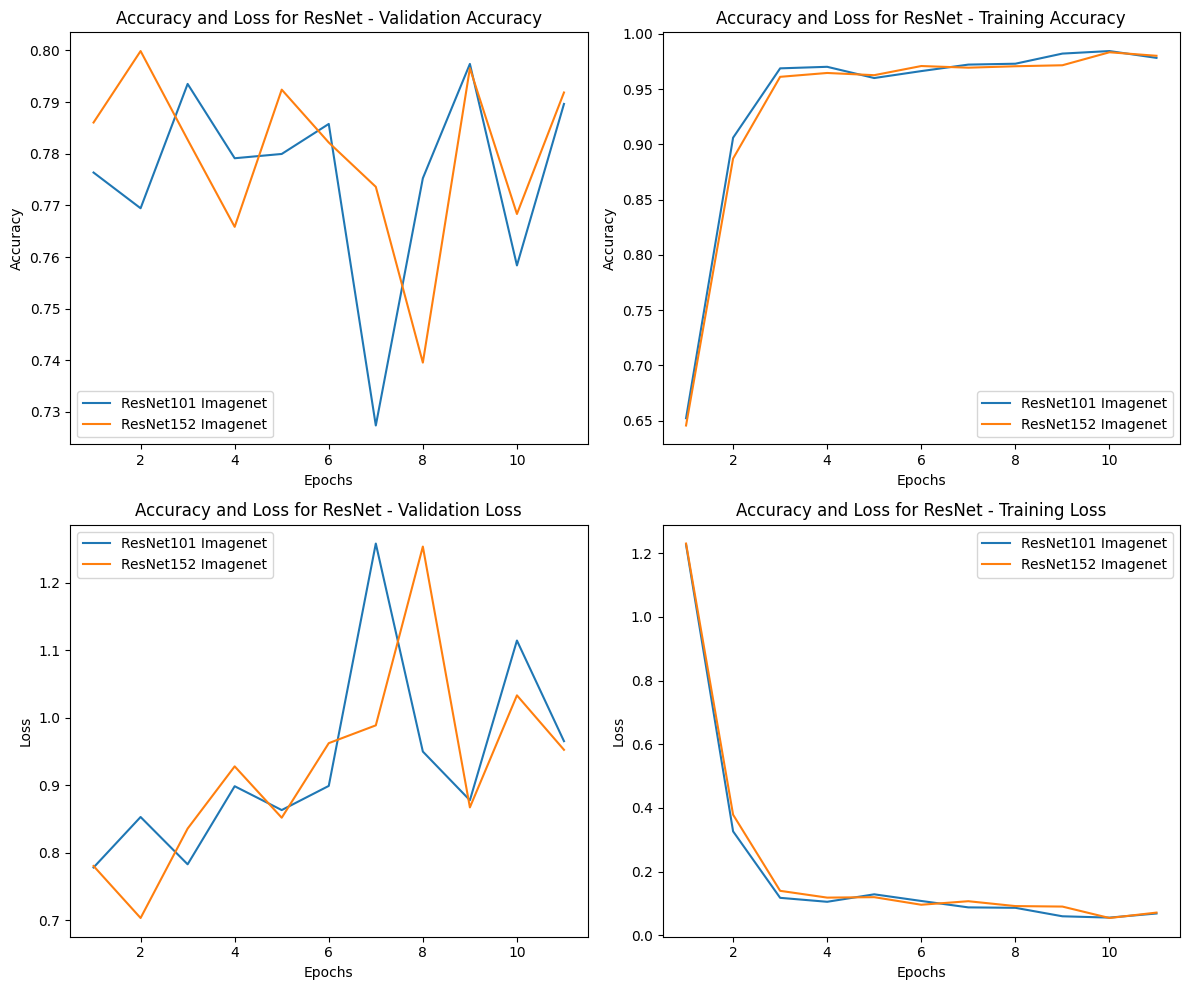

In [ ]:
models_hist = [history_ResNet50_imagenet, history_ResNet101_imagenet, history_ResNet152_imagenet]

models_name = ['ResNet50 Imagenet', 'ResNet101 Imagenet', 'ResNet152 Imagenet']

train_val_plot(models_hist, models_name, 'Accuracy and Loss for ResNet')

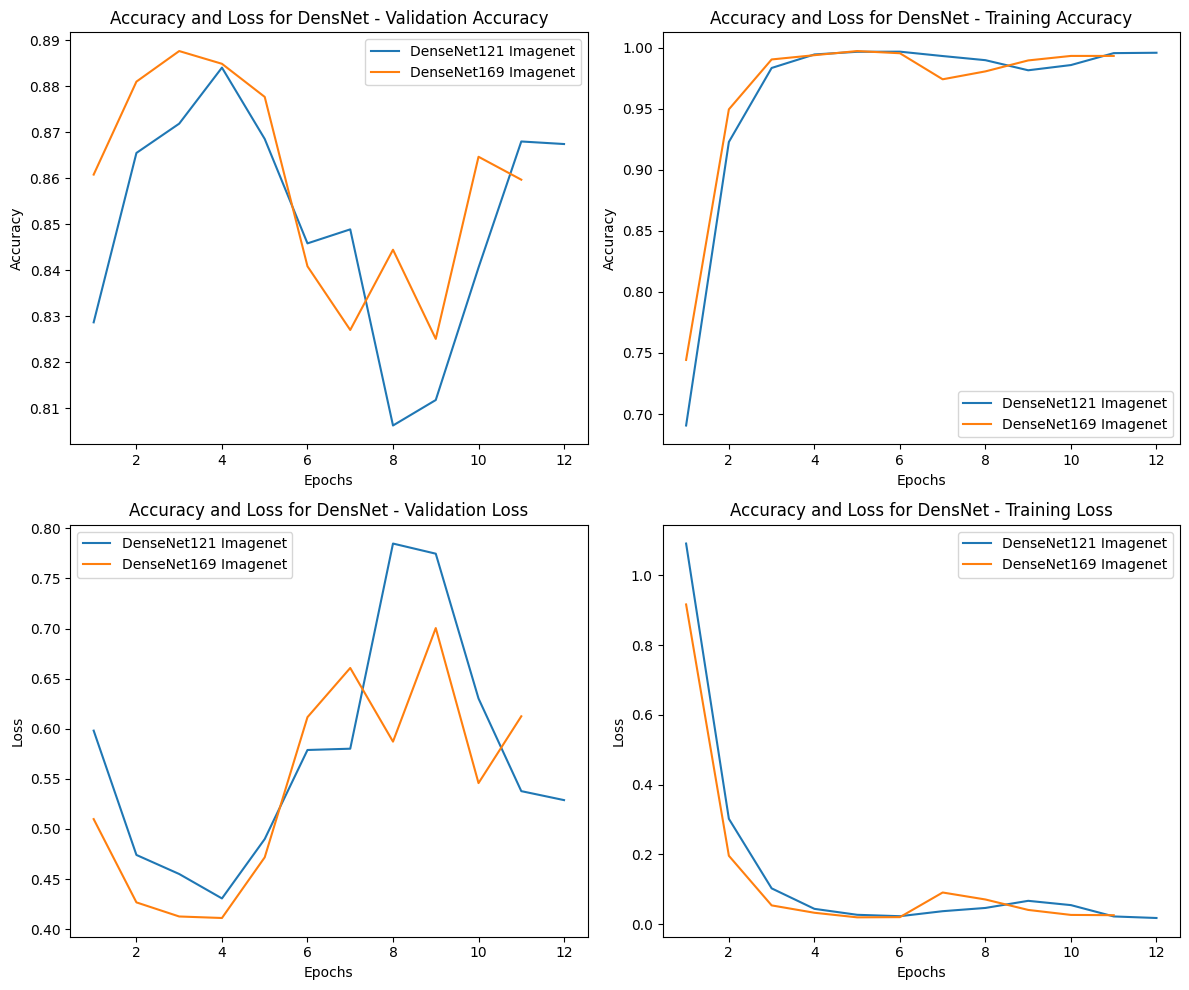

In [ ]:
models_hist = [history_DenseNet121_imagenet, history_DenseNet169_imagenet, history_DenseNet201_imagenet]

models_name = ['DenseNet121 Imagenet', 'DenseNet169 Imagenet', 'DenseNet201 Imagenet']

train_val_plot(models_hist, models_name, 'Accuracy and Loss for DensNet')

#### Confusion Matrix

In [ ]:
models = [VGG_imagenet, AlexNet_imagenet, ResNet50_imagenet,
               InceptionV3_imagenet, MobileNet_imagenet, Xception_imagenet,
               InceptionResNetV2_imagenet, DenseNet121_imagenet]

models_name = ['VGG Imagenet', 'AlexNet Imagenet', 'ResNet50 Imagenet',
               'InceptionV3 Imagenet', 'MobileNet Imagenet', 'Xception Imagenet',
               'InceptionResNetV2 Imagenet', 'DenseNet121 Imagenet']

true_labels, pred_labels = evaluate_models(models, validation_generator)
plot_confusion_matrix(true_labels, pred_labels, models_name)

In [ ]:
models = [ResNet50_imagenet, ResNet101_imagenet, ResNet152_imagenet]

models_name = ['ResNet50 Imagenet', 'ResNet101 Imagenet', 'ResNet152 Imagenet']

true_labels, pred_labels = evaluate_models(models, validation_generator)
plot_confusion_matrix(true_labels, pred_labels, models_name)

In [ ]:
models = [DenseNet121_imagenet, DenseNet169_imagenet, DenseNet201_imagenet]

models_name = ['DenseNet121 Imagenet', 'DenseNet169 Imagenet', 'DenseNet201 Imagenet']

# models = [DenseNet121_imagenet, DenseNet169_imagenet]

# models_name = ['DenseNet121 Imagenet', 'DenseNet169 Imagenet']

valid_generator = DataGenerator(dataframe=df_valid, batch_size=1024, target_size=target_size)

true_labels, pred_labels = evaluate_models(models, valid_generator)
plot_confusion_matrix(true_labels, pred_labels, models_name)

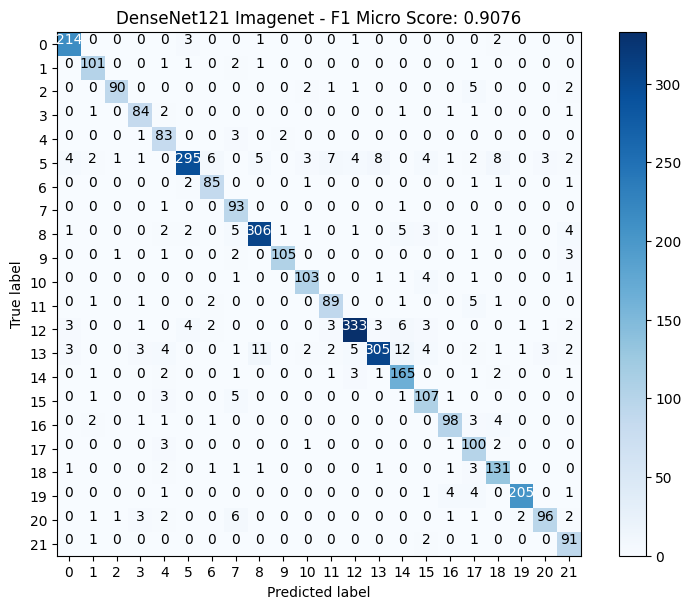

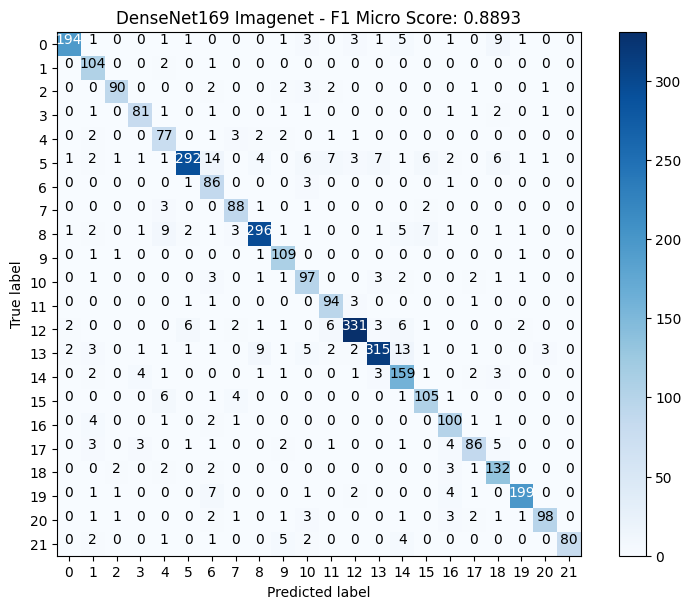

In [ ]:
plot_confusion_matrix(true_labels, pred_labels, models_name)

### Using Data Augmentation

In [ ]:
# label_in_array = np.eye(len(categories))
min_class_index = np.argmin(list(Counter(y_train).values()))
min_size = Counter(y_train)[np.argmin(list(Counter(y_train).values()))]

sampling_strategy = 0.5

ratio = {class_label: sampling_strategy for class_label in range(len(categories))}
for num in np.where(np.array(list(Counter(y_train).values())) * sampling_strategy < min_size)[0]:
    ratio[list(Counter(y_train).keys())[num]] = 1
target_balance_ratios = {class_label: int(max(Counter(y_train)[class_label]*ratio[class_label], min_size))  for class_label in range(len(categories))}

rus = RandomUnderSampler(random_state=42, sampling_strategy=target_balance_ratios)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Print the distribution of classes after undersampling
print("Distribution of classes after undersampling:")
print(Counter(y_res))

Distribution of classes after undersampling:
Counter({8: 844, 13: 828, 12: 800, 5: 794, 14: 740, 18: 595, 19: 536, 0: 528, 6: 519, 10: 514, 3: 507, 2: 505, 7: 497, 17: 495, 11: 494, 4: 493, 21: 490, 1: 479, 9: 478, 15: 469, 16: 463, 20: 457})


In [ ]:
## Data Augmentation

from keras.preprocessing.image import ImageDataGenerator

max_samples = Counter(y_res)[np.argmax(list(Counter(y_res).values()))]

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for category, count in enumerate(sum(y_res)):
    if count < max_samples:

        X_category = X_res[np.where([np.argmax(i) for i in y_res] == category)]
        y_category = y_res[[np.argmax(i) for i in y_res] == category]

        num_additional_samples = max_samples - count
        augmented_images_generator = datagen.flow(X_category, y_category, batch_size=num_additional_samples)
        X_augmented, y_augmented = augmented_images_generator.next()

        X_res = np.concatenate([X_res, X_augmented])
        y_res = np.concatenate([y_res, y_augmented])